<a href="https://colab.research.google.com/github/Gooogr/Book_nlp_with_transformers/blob/main/ch2_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Example of sentiment analysis. <br>
Cover:
* Hugging face (HF) Datasets (load and process datasets)
* HF Tokenizers (tokenize input text)
* HF Transformers (load, train and infer models)
* HF Datasets (load metrics and model evaluation)

In [ ]:
!pip install -qq transformers[sentencepiece] datasets

In [105]:
import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.decomposition import PCA #instead of UMAP 
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
import torch
from torch.nn.functional import cross_entropy

### Download data

In [3]:
all_datasets_names = datasets.list_datasets()
print(f'Total amount of datasets: {len(all_datasets_names)}')
print(f'The first 5 are: {all_datasets_names[:5]}')

Total amount of datasets: 4832
The first 5 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus']


In [4]:
emotion = datasets.load_dataset('emotion')

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
emotion['train'][:5] #note to apache arraw format. We got lists, not individual elements!

{'label': [0, 0, 3, 2, 3],
 'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy']}

### EDA

In [7]:
emotion.set_format(type='pandas') # to simplify EDA part

In [8]:
df = emotion['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [9]:
def label_int2str(x):
    '''
    Decode label index to str category. Use int2str method.
    '''
    return emotion['train'].features['label'].int2str(x)

In [10]:
df['label_name'] = df['label'].apply(label_int2str)

In [11]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


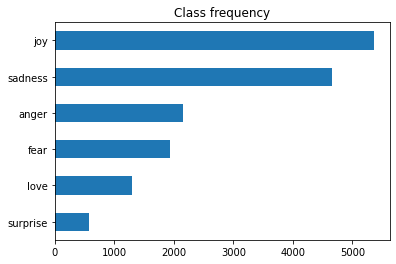

In [12]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Class frequency')
plt.show()

Dataset in imbalanced. But for simplification we will skip any upsepmling/downsampling steps.

In [13]:
df['words_per_tweet'] = df['text'].str.split().apply(lambda x: len(x))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


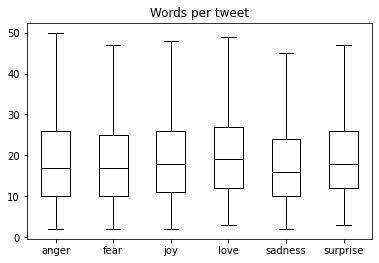

In [14]:
df.boxplot(column="words_per_tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.title('Words per tweet')
plt.xlabel("")
plt.show()

In general tweets have similar length. Mode value is 15.

In [15]:
emotion.reset_format()

### Tokenization

We will use WordPiece wich is part of BERT and DistilBERT pipelines.

In [16]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [17]:
example_text = "Tokenizing text is a core task of NLP"

# encode
encoded_text = tokenizer(example_text)
print(encoded_text)

# convert to tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'])
print(tokens)

# convert to string
string = tokenizer.convert_tokens_to_string(tokens)
print(string)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '[SEP]']
[CLS] tokenizing text is a core task of nlp [SEP]


Ok, time to tokenize our dataset

In [18]:
#emotion['train']['text']

In [19]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [20]:
tokenize(emotion['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

First tweet is shorter the the second, the it was padded by zeros to make equal length. Attantion mask hided these additional zeroes.

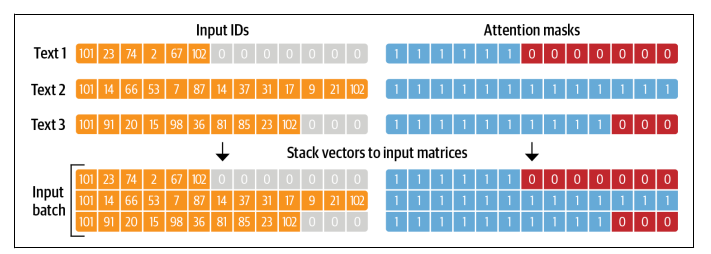

Apply tokenizer to our dataset

In [21]:
emotion_encoded = emotion.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [22]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

### Classifier training

#### Option 1: Feature extraction without fine-tuning
We will create dataset based on extracted vectors from the hidden state layer and train separate classifier.

In [23]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)
print('device in use:', device)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


device in use: cuda


Minimal text exmaple

In [25]:
test_text = "my not so random text"
inputs = tokenizer(test_text, return_tensors='pt')
print(inputs)

{'input_ids': tensor([[ 101, 2026, 2025, 2061, 6721, 3793,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [26]:
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad(): #speed up process by skipping gradient computation
    outputs = model(**inputs)

In [31]:
print(outputs)
print('Output shape:', outputs.last_hidden_state.shape)

BaseModelOutput(last_hidden_state=tensor([[[-0.0892, -0.0081, -0.0051,  ..., -0.0262,  0.2581,  0.3353],
         [ 0.2927,  0.2716,  0.0713,  ..., -0.1289,  0.3239,  0.6273],
         [-0.2575, -0.5480,  0.3669,  ..., -0.0788,  0.1956,  0.2625],
         ...,
         [ 0.1957, -0.4156, -0.0467,  ..., -0.2477,  0.0410, -0.1942],
         [ 0.1185, -0.1716,  0.0189,  ...,  0.1070, -0.0661,  0.2182],
         [ 0.9167,  0.2103, -0.4431,  ...,  0.1040, -0.3891, -0.2886]]],
       device='cuda:0'), hidden_states=None, attentions=None)
Output shape: torch.Size([1, 7, 768])


Ok, apply this method to the whole dataset

In [35]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [36]:
def extract_hidden_state(batch):
    # Send model inputs to device
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    #Extract the last hidden state
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # For classificattion tasks it's common to use only hidden state vector for [CLS] token
    # Return vector for [CLS] token
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}


In [41]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [40]:
# Convert input_ids and attention_mask to the torch format
emotion_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [42]:
emotion_hidden = emotion_encoded.map(extract_hidden_state, batched=True) # batched=True, so default batch_size will be 1000

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [43]:
emotion_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

Creating a feature matrix

Now we can prepare dataset for classifier training

In [46]:
X_train = np.array(emotion_hidden["train"]["hidden_state"])
X_valid = np.array(emotion_hidden["validation"]["hidden_state"])
y_train = np.array(emotion_hidden["train"]["label"])
y_valid = np.array(emotion_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Hidden states visualizations

In [57]:
# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit PCA/UMAP
pca_emdebings = PCA(n_components=2).fit_transform(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(pca_emdebings, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,0.052285,-2.044845,0
1,-0.611239,0.071186,0
2,0.172693,-1.991039,3
3,-0.632667,0.384492,2
4,-1.145685,-0.882579,3


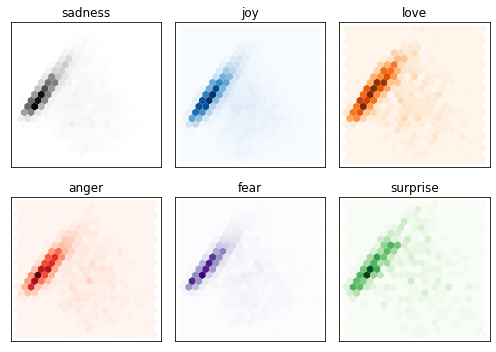

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotion["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
    gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

Training simple classifier

In [65]:
%%time
lr_clf = LogisticRegression(solver='saga', 
                            max_iter=1000, # 1000 will garantee convergence
                            n_jobs=-1, 
                            penalty='l2',
                            verbose=True) 
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='saga')

In [68]:
print('Valid accuracy:', lr_clf.score(X_valid, y_valid))

Valid accuracy: 0.633


Better than random :)

In [70]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

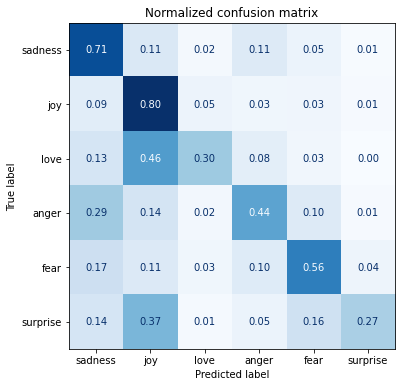

In [71]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

Problem to separate love - joy - surprise, sadness-anger

#### Option 2: Fine-tuning transformers

Loading pre-trained model. Use AutoModelForSequenceClassification has build in classification head. But the model the same - DistilBERT

In [75]:
num_labels = 6
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels=num_labels)
        .to(device))
# warning because of the randonly initialized classification head

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

Define metrics

In [94]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return{"accuracy":acc, "f1":f1}

Train model

In [90]:
batch_size = 64
logging_steps = len(emotion_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

In [96]:
logging_steps

250

In [91]:
training_args = TrainingArguments(output_dir=model_name,
                                num_train_epochs=2,
                                learning_rate=2e-5,
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                weight_decay=0.01,
                                evaluation_strategy="epoch",
                                disable_tqdm=False,
                                logging_steps=logging_steps,
                                push_to_hub=False, #let's skip this stuff
                                log_level="error")

In [92]:
emotion_encoded['validation']

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})

In [97]:
trainer = Trainer(model=model, 
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotion_encoded["train"],
                  eval_dataset=emotion_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.100000,0.189793,0.926000,0.926409
2,0.104700,0.163724,0.935000,0.935094


TrainOutput(global_step=500, training_loss=0.10235523986816407, metrics={'train_runtime': 234.804, 'train_samples_per_second': 136.284, 'train_steps_per_second': 2.129, 'total_flos': 720342861696000.0, 'train_loss': 0.10235523986816407, 'epoch': 2.0})

0.935 💪

Getting results

In [99]:
preds_output = trainer.predict(emotion_encoded["validation"])

In [101]:
preds_output.metrics

{'test_accuracy': 0.935,
 'test_f1': 0.9350943857274716,
 'test_loss': 0.16372406482696533,
 'test_runtime': 4.9488,
 'test_samples_per_second': 404.135,
 'test_steps_per_second': 6.466}

In [102]:
y_preds = np.argmax(preds_output.predictions, axis=1)

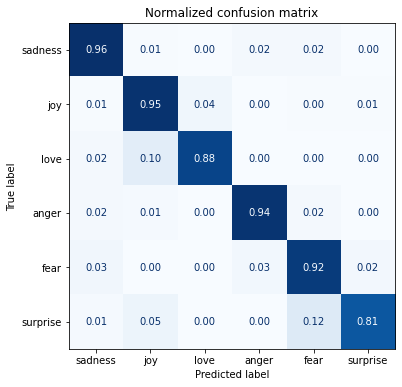

In [104]:
plot_confusion_matrix(y_preds, y_valid, labels)

Error analysis

In [106]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
        reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [108]:
# Convert our dataset back to PyTorch tensors
emotion_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotion_encoded["validation"] = emotion_encoded["validation"].map(forward_pass_with_label, 
                                                                  batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [111]:
emotion_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotion_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [113]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,9.028975
882,i feel badly about reneging on my commitment t...,love,sadness,8.473310
1195,i always think about are act the way i want to...,anger,joy,8.293082
1111,im lazy my characters fall into categories of ...,joy,fear,7.786015
1963,i called myself pro life and voted for perry w...,joy,sadness,7.078388
1500,i guess we would naturally feel a sense of lon...,anger,sadness,7.012499
1509,i guess this is a memoir so it feels like that...,joy,fear,6.351780
1870,i guess i feel betrayed because i admired him ...,joy,sadness,6.282023
1852,i arrived home with a strange feeling of happi...,sadness,fear,4.982881
1367,that day i was alone at home after coming home...,fear,sadness,4.819684


In [114]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
69,i have no extra money im worried all of the ti...,sadness,sadness,0.001049
1310,i feel like an ungrateful asshole,sadness,sadness,0.001085
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.001112
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.001115
1873,i feel practically virtuous this month i have ...,joy,joy,0.001126
394,i feel shamed that i hoped for one last christ...,sadness,sadness,0.001133
1303,i feel pathetic and uninspired,sadness,sadness,0.001134
620,i shall move right along to the post interview...,joy,joy,0.001142
396,i feel pretty pathetic now,sadness,sadness,0.001153
507,i always feel so inadequate,sadness,sadness,0.001153


Custom example

In [117]:
# custom_tweet = "I saw a movie today and it was really good."
# preds = model(custom_tweet, return_all_scores=True)